In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import os

#**Problem Statement**

I recently got hired at a private medical company to build a machine learning pipeline to classify images of brain tumors. For this task, I acquired a dataset with over 7000 images of various brain tumors. A brain tumor is an accumulative of abnormal brain cells in your brain. Once the malignant tumor grows, it can person a brain damage which can be very life threatening. So in order to prevent this from happening to patients, I will build a deep neural network that will predict and detect the tumors in their early stages and help save lives of people. This project is formulated as a classification task of brain MRI images.



---



#**Data Collection**

First, I import my dataset through google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The code lines below are used to load the images from training and test sets. Then I resize all images to 150 by 150 pixels and each batch size to contain 32 images. The labels are classified as categorical, so they will be one-hot encoded vectors.

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/brain_dataset/Training',
    image_size=(150, 150),
    batch_size=32,
    label_mode='categorical'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/brain_dataset/Testing',
    image_size=(150, 150),
    batch_size=32,
    label_mode='categorical'
)

Found 5732 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


Here I print class names for my dataset

In [ ]:
class_names = train_dataset.class_names
print(f"Class names: {class_names}")

Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


The code below is used to split the training data into training and validation sets. The size of validation split is set at 20% meaing 20% of training of data will be used for validation.

In [ ]:
validation_split = 0.2
dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

val_dataset = train_dataset.take(val_size)
train_dataset = train_dataset.skip(val_size)

print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")

Training set size: 144
Validation set size: 36




---



#**Data Exploration**

This function outputs number of images in each class for training set

In [ ]:
train_class_counts = {class_name: 0 for class_name in class_names}
for images, labels in train_dataset:
    for label in labels:
        class_idx = np.argmax(label)
        class_name = class_names[class_idx]
        train_class_counts[class_name] += 1

print("Training set class distribution:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count}")

Training set class distribution:
glioma: 1058
meningioma: 1087
notumor: 1247
pituitary: 1188


This one to output number of images in each class in validation set

In [ ]:
val_class_counts = {class_name: 0 for class_name in class_names}
for images, labels in val_dataset:
    for label in labels:
        class_idx = np.argmax(label)
        class_name = class_names[class_idx]
        val_class_counts[class_name] += 1

print("Validation set class distribution:")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count}")

Validation set class distribution:
glioma: 263
meningioma: 259
notumor: 352
pituitary: 278


And finally the third one to get output for test test

In [ ]:
test_class_counts = {class_name: 0 for class_name in class_names}
for images, labels in test_dataset:
    for label in labels:
        class_idx = np.argmax(label)
        class_name = class_names[class_idx]
        test_class_counts[class_name] += 1

print("Test set class distribution:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")

Test set class distribution:
glioma: 300
meningioma: 306
notumor: 405
pituitary: 300


Here I decide to plot a visualization of 9 images from each class of my dataset

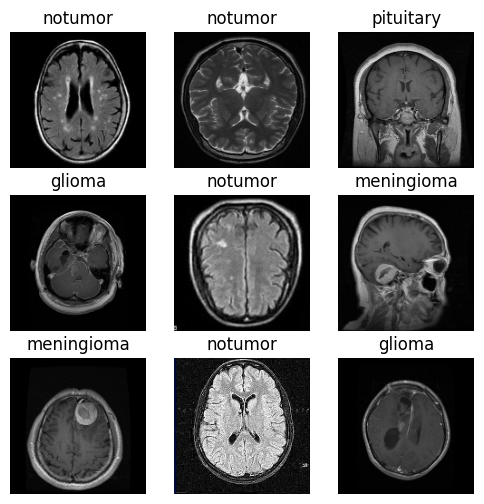

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.show()



---



#**Data Preprocessing**

The functions under help machine to convert images and label batches to numpy arrays. It can ber memory efficient for computer and provide flexibility when using other numpy functionalitites

In [ ]:
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for img_batch, lbl_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(lbl_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

train_images, train_labels = dataset_to_numpy(train_dataset)
val_images, val_labels = dataset_to_numpy(val_dataset)
test_images, test_labels = dataset_to_numpy(test_dataset)

The code below converts data type to float32, which ensures division operations are performed correctly. The second part divides pixels value range by 255 to scale it down to a range of 0 to 1 from 0 to 255

In [ ]:
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0



---



#**Building And Training The Best Model**

Now for this section of my pipeline, I design a function to find my best model. In order to do that, first I initialize Sequential model which is a linear stack of layers. Then I add 2D convolutional layer with 32 filters size of 3 by 3. For activation function I use relu and input the shape of images to 150x150 pixels. Then I add maxpooling2d layer with pool size 2x2 to reduce spatial dimensions of the output volume. Flatten layer converts 2D output into 1D vector. After, I add Dense layer with 4 units and softmax activation to produce probability distribution over 4 classes. At the end, I compile model with adam optimizer and categorical cross-entropy loss function.

In [ ]:
def build_model(layers):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    for layer in layers:
        model.add(layer)
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Here I apply Early stopping callback, which monitors validation loss and stops once it reaches minimum. Patience is set to 5, meaning training will run 5 additional epochs after last time validation loss improved. And the last functions ensures the final model has the weights from epoch with best perfomance.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Now I train the best model I discovered and reach max val accuracy of 0.9479

In [ ]:
best_layers = [Dense(512, activation='relu'), Dropout(0.5)]
best_model = build_model(best_layers)
history = best_model.fit(train_images, train_labels, epochs=100, validation_data=(val_images, val_labels), callbacks=[early_stopping])

Epoch 1/100
144/144 [==============================] - 7s 20ms/step - loss: 1.4247 - accuracy: 0.7207 - val_loss: 0.3086 - val_accuracy: 0.8976
Epoch 2/100
144/144 [==============================] - 2s 12ms/step - loss: 0.2628 - accuracy: 0.9057 - val_loss: 0.2064 - val_accuracy: 0.9314
Epoch 3/100
144/144 [==============================] - 2s 12ms/step - loss: 0.1380 - accuracy: 0.9537 - val_loss: 0.1734 - val_accuracy: 0.9427
Epoch 4/100
144/144 [==============================] - 2s 12ms/step - loss: 0.0820 - accuracy: 0.9738 - val_loss: 0.1562 - val_accuracy: 0.9479
Epoch 5/100
144/144 [==============================] - 2s 11ms/step - loss: 0.0442 - accuracy: 0.9865 - val_loss: 0.2259 - val_accuracy: 0.9401
Epoch 6/100
144/144 [==============================] - 2s 11ms/step - loss: 0.0362 - accuracy: 0.9886 - val_loss: 0.2104 - val_accuracy: 0.9436
Epoch 7/100
144/144 [==============================] - 2s 11ms/step - loss: 0.0301 - accuracy: 0.9895 - val_loss: 0.1695 - val_accuracy:



---



#**Experimentation and Evaluation**

For experimental section, I came up with 10 different configurations to try to see how one of them affects the perfomance of the model. I tried decreasing number of dense layers or remove dropout or add BatchNormalization and many other variations. Surprisingly, none of them significantly decreased the perfomance of the model. The lowest validation accuracy I got was 0.928819 when I used [Dense(64, activation='relu'), Dropout(0.2), BatchNormalization()] configuration. The possible reason for this is that my dataset is very well balanced and my model configs are still relatively robust.

In [ ]:
configs = [
    [Dense(128, activation='relu'), Dropout(0.5)],
    [Dense(256, activation='relu'), Dropout(0.3)],
    [Dense(128, activation='relu'), Dropout(0.3)],
    [Dense(256, activation='relu')],
    [Dense(64, activation='relu'), Dropout(0.2), BatchNormalization()],
    [Dense(128, activation='relu'), Dropout(0.4)],
    [Dense(256, activation='relu'), BatchNormalization()],
    [Dense(256, activation='relu'), Dropout(0.9)],
    [Dense(128, activation='relu'), BatchNormalization()],
    [Dense(64, activation='relu'), Dropout(0.1), BatchNormalization()]
]

results = []
for i, config in enumerate(configs):
    model = build_model(config)
    history = model.fit(train_images, train_labels, epochs=100, validation_data=(val_images, val_labels), verbose=0, callbacks=[early_stopping])
    val_accuracy = history.history['val_accuracy'][-1]
    results.append({
        'Model': f'Model {i+1}',
        'Layers': [layer.__class__.__name__ for layer in config],
        'Validation Accuracy': val_accuracy
    })

df_results = pd.DataFrame(results)
display(df_results)

,Model,Layers,Validation Accuracy
0,Model 1,"[Dense, Dropout]",0.947917
1,Model 2,"[Dense, Dropout]",0.937500
2,Model 3,"[Dense, Dropout]",0.940972
3,Model 4,[Dense],0.937500
4,Model 5,"[Dense, Dropout, BatchNormalization]",0.928819
5,Model 6,"[Dense, Dropout]",0.939236
6,Model 7,"[Dense, BatchNormalization]",0.940104
7,Model 8,"[Dense, Dropout]",0.938368
8,Model 9,"[Dense, BatchNormalization]",0.934896
9,Model 10,"[Dense, Dropout, BatchNormalization]",0.932292


At the end, I evaluete accuracy of my best model on test set and get 94.1% accuracy

In [ ]:
test_loss, test_acc = best_model.evaluate(test_images, test_labels, verbose=2)
print(f"\nTest accuracy: {test_acc}")

41/41 - 0s - loss: 0.1874 - accuracy: 0.9413 - 373ms/epoch - 9ms/step

Test accuracy: 0.9412662386894226




---



#**Conclusion**

In the conclusion, I have built a very robust end-to-end machine learning pipeline using deep neural network. To achieve this goal, I went through a multiple of processes such as collection, exploration, and preprocessing of data. After finishing with that, I have built a best model through comprehensive experimentation with different models, layers, and configurations. The dropout seems to have contributed the most to the performance of the model, as it helps to prevent overfitting. In the end, the accuracy of 94.1% has been achieved on unseen test set which is very promising. This results means there is a huge potential for deployment of this tech in real-world applications of the company. Automation of images with the use of deep neural network provides a reliable solution to improve accuracy and efficiency of brain tumor detection, ultimately benefitting healthcare environment.

Reference for the dataset- https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data